# 0. Imports

In [3]:
import pickle
import json
import requests
import math

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import xgboost           as xgb


from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.metrics         import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from flask                   import Flask, request, Response

# 1. Collecting Dataset

In [4]:
df0 = pd.read_csv('data/Abandono_clientes.csv')

In [5]:
df_teste = pd.read_csv('data/Abandono_teste.csv',sep=';')

In [6]:
df_teste['Gender'].value_counts()

Gender
Male      567
Female    433
Name: count, dtype: int64

# 2. Exploratory Data Analysis

In [7]:
df1 = df0.copy()

## 2.1. Checking NAs and Data types

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## 2.2. Variaveis Categoricas

In [9]:
# Desbalanceamento de Dados
df1['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [10]:
# Verifciando Variaveis Categoricas
df1['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [11]:
df1['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

## 2.3. Variaveis Numericas

In [12]:
df1.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


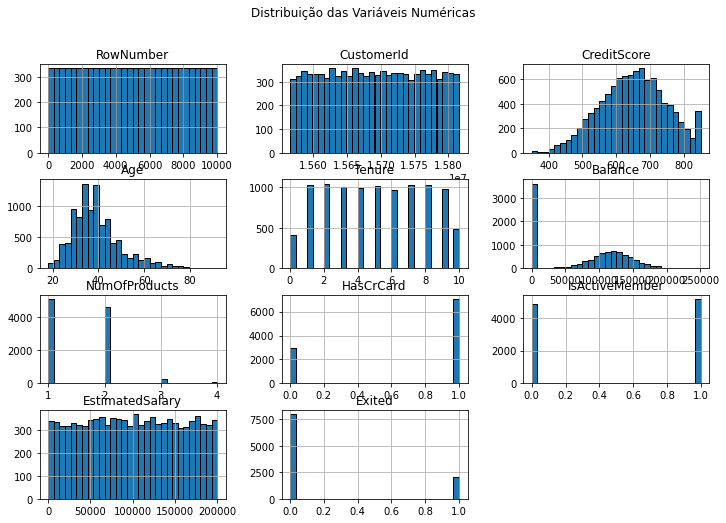

In [13]:
df1.hist(figsize=(12, 8), bins=30, edgecolor="black")
plt.suptitle("Distribuição das Variáveis Numéricas")
plt.show()

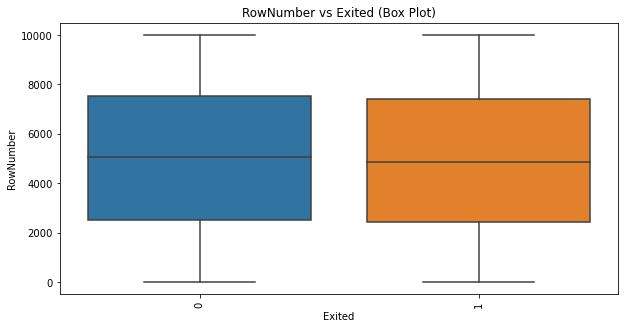

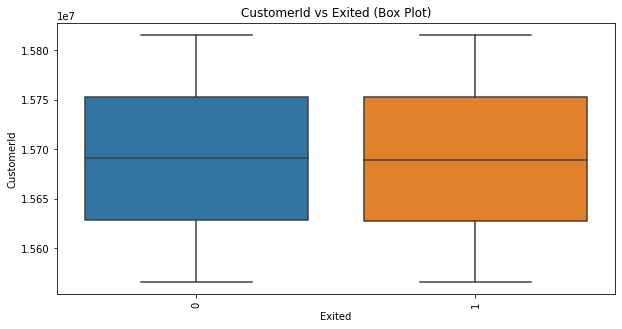

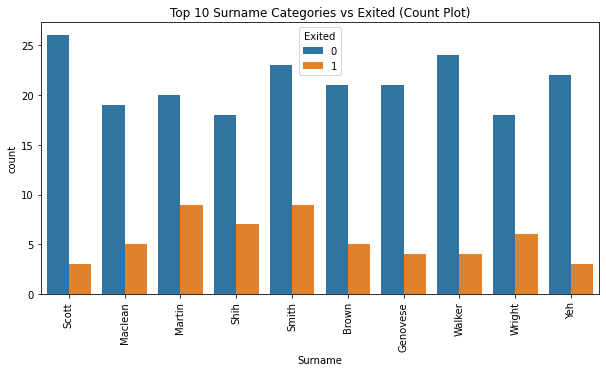

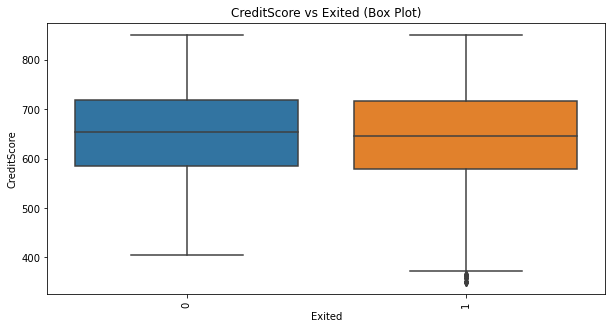

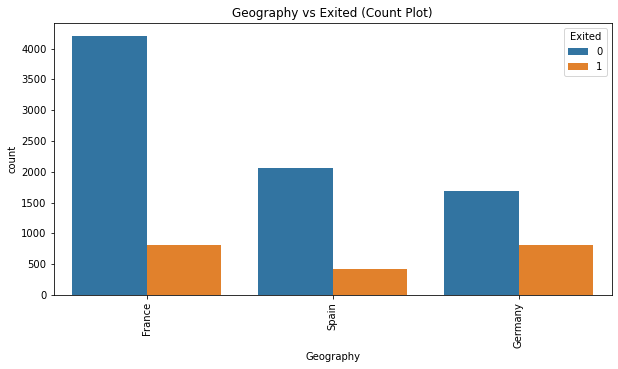

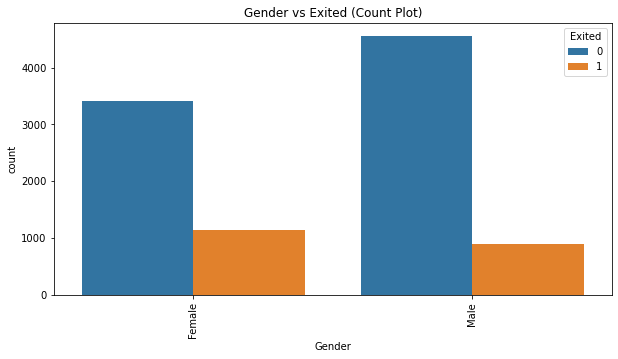

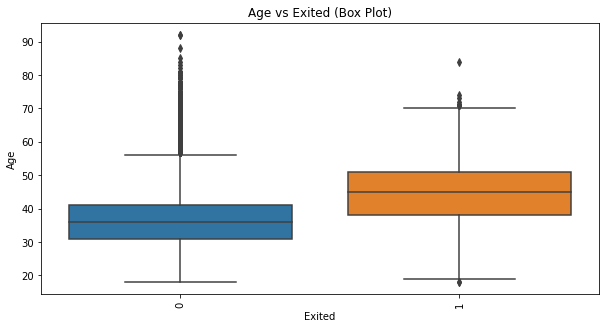

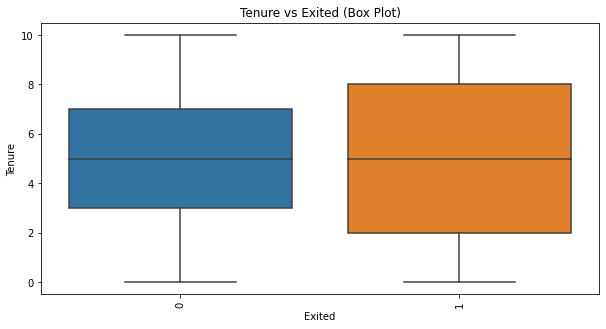

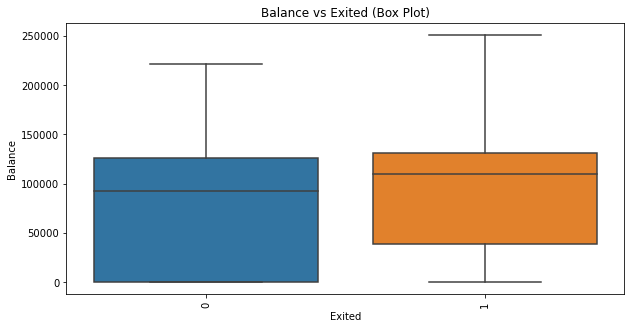

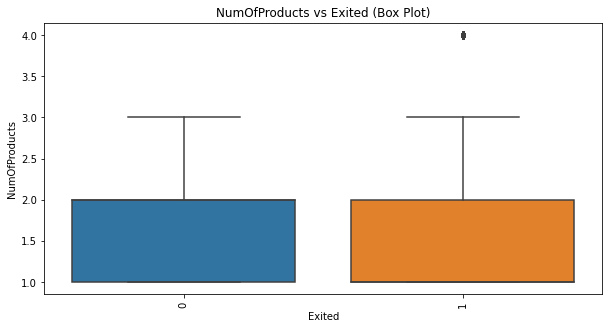

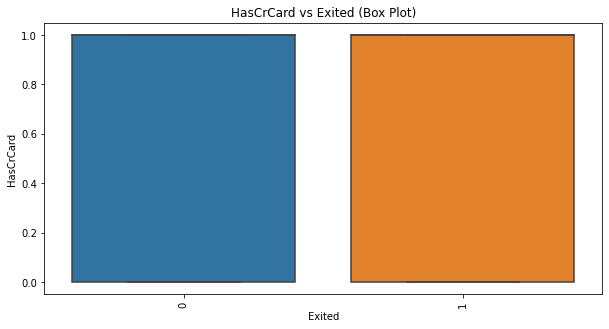

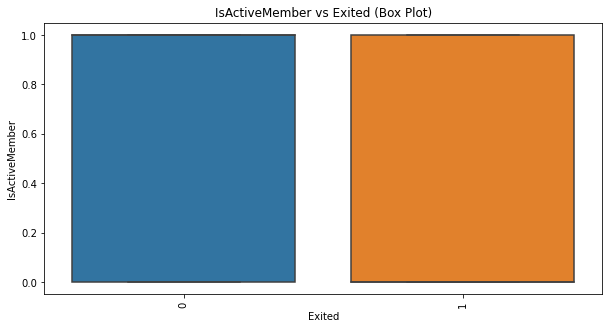

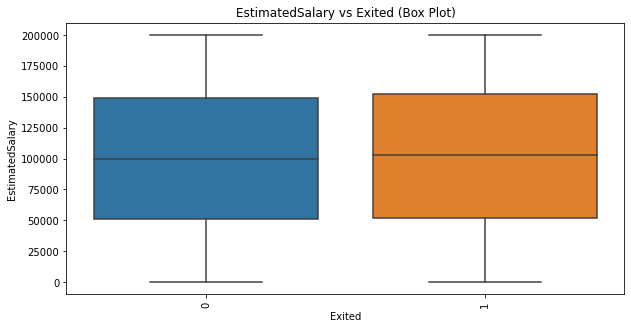

In [14]:
def univariate_analysis(df, target):
    # Separate numerical and categorical features
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    for col in df.columns:
        if col == target:
            continue

        plt.figure(figsize=(10, 5))
        if col in num_cols:
            # Numerical feature
            sns.boxplot(x=target, y=col, data=df)
            plt.title(f'{col} vs {target} (Box Plot)')
        elif col in cat_cols:
            # Categorical feature
            if df[col].nunique() > 10:
                # Show only top 10 categories by frequency
                top_10_categories = df[col].value_counts().head(10).index
                temp_df = df[df[col].isin(top_10_categories)]
                sns.countplot(x=col, hue=target, data=temp_df)
                plt.title(f'Top 10 {col} Categories vs {target} (Count Plot)')
            else:
                sns.countplot(x=col, hue=target, data=df)
                plt.title(f'{col} vs {target} (Count Plot)')
        plt.xticks(rotation=90)
        plt.show()


univariate_analysis(df0, "Exited")

# 3. Feature Engineering

In [15]:
# Criando Dummies para Paises (Geography - apenas 3: Franca, Alemanha e Espanha)
df1_encoded = pd.get_dummies(df1,columns=['Geography','Gender'])

In [16]:
# Retirando SURNAME (Sobrenome) e RowNumber, pois nao agregam
df2 = df1_encoded.drop(['Surname','RowNumber'],axis=1)

In [17]:
df2

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,True,False,False,True,False
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,False,False,True,True,False
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,True,False,False,True,False
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,True,False,False,True,False
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,39,5,0.00,2,1,0,96270.64,0,True,False,False,False,True
9996,15569892,516,35,10,57369.61,1,1,1,101699.77,0,True,False,False,False,True
9997,15584532,709,36,7,0.00,1,0,1,42085.58,1,True,False,False,True,False
9998,15682355,772,42,3,75075.31,2,1,0,92888.52,1,False,True,False,False,True


# 4. Creating Base Line Model

In [18]:
df2['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

## 4.1. Using Split 

In [19]:
# Separar as classes
df_class_0 = df2[df2['Exited'] == 0]  # Classe 0 (No Churn)
df_class_1 = df2[df2['Exited'] == 1]  # Classe 1 (Churn)

In [20]:
# Para a classe 0, dividir normalmente (por exemplo, 80-20)
df_train_0, df_test_0 = train_test_split(df_class_0, test_size=0.20)#, random_state=50)# 42 50 123

# Dividir apenas a classe 1 com 30% para teste
df_train_1, df_test_1 = train_test_split(df_class_1, test_size=0.30)#, random_state=50)

In [21]:
# Juntar os datasets desbalanceados
df_train = pd.concat([df_train_0, df_train_1], axis=0).sample(frac=1) # Embaralha os dados
df_test  = pd.concat([df_test_0, df_test_1], axis=0).sample(frac=1)

In [22]:
X_train = df_train.drop('Exited',axis=1)
y_train = df_train['Exited']

x_test  = df_test.drop('Exited',axis=1)
y_test  = df_test['Exited']

## 4.2. Evaluating Models

In [23]:
# Criar e treinar os modelos
models = {
    "Regressao Logistica": LogisticRegression(),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost" : xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", n_estimators=100)
}


Modelo: K-Nearest Neighbors (KNN)
Acurácia: 0.7020
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.72      0.95      0.82      1593
           1       0.31      0.06      0.10       612

    accuracy                           0.70      2205
   macro avg       0.52      0.50      0.46      2205
weighted avg       0.61      0.70      0.62      2205



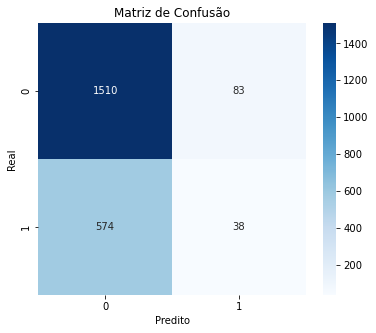

In [44]:
# K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(x_test)
print(f"\nModelo: K-Nearest Neighbors (KNN)")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Criar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Criar a visualização
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()


Modelo: LogisticRegression
Acurácia: 0.7224
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1593
           1       0.00      0.00      0.00       612

    accuracy                           0.72      2205
   macro avg       0.36      0.50      0.42      2205
weighted avg       0.52      0.72      0.61      2205



C:\Users\fe057272\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fe057272\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fe057272\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


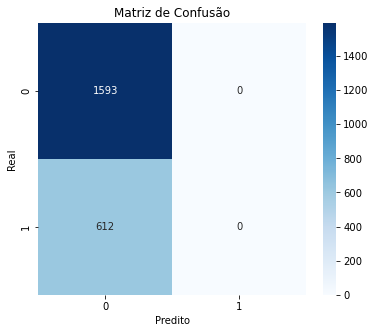

In [25]:
# Regressao Logistica
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(x_test)
print(f"\nModelo: LogisticRegression")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Criar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Criar a visualização
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()


Modelo: RandomForestClassifier
Acurácia: 0.8277
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.86      0.45      0.59       612

    accuracy                           0.83      2205
   macro avg       0.84      0.71      0.74      2205
weighted avg       0.83      0.83      0.81      2205



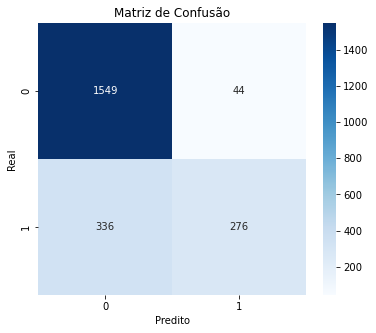

In [26]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(x_test)
print(f"\nModelo: RandomForestClassifier")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Criar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Criar a visualização
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

C:\Users\fe057272\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [14:25:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Modelo: XGBClassifier
Acurácia: 0.8231
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1593
           1       0.79      0.49      0.61       612

    accuracy                           0.82      2205
   macro avg       0.81      0.72      0.75      2205
weighted avg       0.82      0.82      0.81      2205



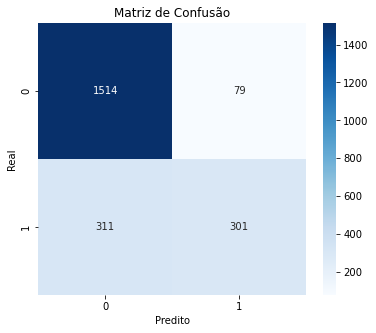

In [27]:
# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", n_estimators=100)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(x_test)
print(f"\nModelo: XGBClassifier")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Criar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Criar a visualização
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# 5. Save trained model

In [103]:
# O metodo escolhido foi o XGBoost
#pickle.dump(xgb_model,open('model/model_randomForest.pkl','wb'))

# API Handler

# Class Model

# API Tester

In [28]:
df_test_0 = df_test[df_test['Exited']==0].sample(10).drop(['Exited'],axis=1)
df_test_0

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
5027,15807989,681,37,8,73179.34,2,1,1,25292.53,False,True,False,False,True
2281,15778320,848,40,5,148495.64,1,0,0,158853.98,False,True,False,True,False
1259,15701265,559,36,1,104356.94,2,0,1,54184.06,False,True,False,True,False
8514,15796071,657,29,7,83889.03,1,1,0,153059.62,False,False,True,False,True
658,15568595,544,64,9,113829.45,1,1,1,124341.49,True,False,False,False,True
1157,15811327,700,54,1,79415.67,1,0,1,139735.54,False,False,True,False,True
9977,15579969,683,32,9,0.00,2,1,1,24991.92,True,False,False,True,False
5597,15815552,670,42,6,112333.63,1,1,1,65706.86,True,False,False,True,False
3290,15748589,736,30,9,0.00,2,1,0,34180.33,True,False,False,True,False
9767,15610419,554,33,3,117413.95,1,1,1,12766.74,True,False,False,False,True


In [29]:
df_test_1 = df_test[df_test['Exited']==1].sample(10).drop(['Exited'],axis=1)
df_test_1

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
4619,15622532,708,47,0,126589.12,2,0,1,132730.07,True,False,False,True,False
2786,15585100,511,40,9,124401.60,1,1,0,198814.24,False,True,False,True,False
8963,15796993,741,52,1,171236.30,2,0,0,21834.40,True,False,False,False,True
1427,15799966,792,59,9,101609.77,1,0,0,161479.19,False,True,False,True,False
7598,15613699,430,60,7,73937.02,1,1,0,161937.62,True,False,False,True,False
8234,15677796,766,47,9,129289.98,1,1,0,169935.46,False,True,False,False,True
6080,15725945,659,42,2,0.00,1,0,0,162734.31,False,False,True,True,False
5024,15720583,745,44,0,119638.21,1,1,1,34265.08,False,True,False,True,False
422,15674551,535,40,7,111756.50,1,1,0,8128.32,False,True,False,False,True
43,15755196,834,49,2,131394.56,1,0,0,194365.76,True,False,False,True,False


In [30]:
df_api_t = pd.concat([df_test_0,df_test_1])
df_api_t.index

Index([5027, 2281, 1259, 8514,  658, 1157, 9977, 5597, 3290, 9767, 4619, 2786,
       8963, 1427, 7598, 8234, 6080, 5024,  422,   43],
      dtype='int64')

In [38]:
df_api_t = df0[df0.index.isin(df_api_t.index)]

In [39]:
# Convertendo para json
# data = json.dumps(df_test_api.to_dict(orient='records'))
data = json.dumps(df_api_t.to_dict(orient='records'))

In [40]:
data

'[{"RowNumber": 1, "CustomerId": 15634602, "Surname": "Hargrave", "CreditScore": 619, "Geography": "France", "Gender": "Female", "Age": 42, "Tenure": 2, "Balance": 0.0, "NumOfProducts": 1, "HasCrCard": 1, "IsActiveMember": 1, "EstimatedSalary": 101348.88, "Exited": 1}, {"RowNumber": 2, "CustomerId": 15647311, "Surname": "Hill", "CreditScore": 608, "Geography": "Spain", "Gender": "Female", "Age": 41, "Tenure": 1, "Balance": 83807.86, "NumOfProducts": 1, "HasCrCard": 0, "IsActiveMember": 1, "EstimatedSalary": 112542.58, "Exited": 0}, {"RowNumber": 3, "CustomerId": 15619304, "Surname": "Onio", "CreditScore": 502, "Geography": "France", "Gender": "Female", "Age": 42, "Tenure": 8, "Balance": 159660.8, "NumOfProducts": 3, "HasCrCard": 1, "IsActiveMember": 0, "EstimatedSalary": 113931.57, "Exited": 1}, {"RowNumber": 4, "CustomerId": 15701354, "Surname": "Boni", "CreditScore": 699, "Geography": "France", "Gender": "Female", "Age": 39, "Tenure": 1, "Balance": 0.0, "NumOfProducts": 2, "HasCrCard

In [41]:
# API call
# url = 'http://0.0.0.0:5000/model_churn/predict'
url = 'http://192.168.1.3:5000/model_churn/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post(url,data=data,headers = header)

print('Status Code {}'.format(r.status_code))

Status Code 200


In [42]:
res = pd.DataFrame(r.json(),columns=r.json()[0].keys())
res

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,prediction
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,15810218,Sun,610,Spain,Male,29,9,0.00,3,0,1,83912.24,0,0
996,997,15645621,Hunter,811,Spain,Male,44,3,0.00,2,0,1,78439.73,0,0
997,998,15608114,Manfrin,587,Spain,Male,62,7,121286.27,1,0,1,6776.92,0,0
998,999,15659557,Artamonova,811,Germany,Female,28,4,167738.82,2,1,1,9903.42,0,0


Acurácia: 0.9310
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       796
           1       0.92      0.73      0.81       204

    accuracy                           0.93      1000
   macro avg       0.93      0.85      0.88      1000
weighted avg       0.93      0.93      0.93      1000



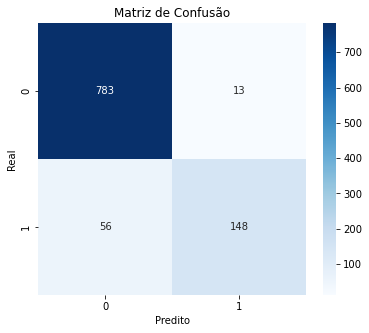

In [43]:
print(f"Acurácia: {accuracy_score(res['Exited'], res['prediction']):.4f}")
print("Relatório de Classificação:")
print(classification_report(res['Exited'], res['prediction']))

# Criar a matriz de confusão
cm = confusion_matrix(res['Exited'], res['prediction'])

# Criar a visualização
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Tunning

Utilizando analise a partir da Matriz Confusao, principalmente F1-Score, que faz uma Média Harmônica com Precision e Recall, o modelo escolhido foi XGBoost.

Dessa forma, será feito uma Tunning em seus parâmetros para extrair a melhor performance.

In [45]:
from sklearn.model_selection import RandomizedSearchCV

# Definir os hiperparâmetros para busca
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Aplicar RandomizedSearchCV para encontrar os melhores hiperparâmetros
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=10, cv=3, scoring='recall', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Melhor combinação encontrada
print("Melhores Hiperparâmetros:", random_search.best_params_)

# Avaliação no conjunto de teste
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(x_test)
print("Acurácia:", accuracy_score(y_test, y_pred))

C:\Users\fe057272\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [14:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores Hiperparâmetros: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0}
Acurácia: 0.8199546485260771


C:\Users\fe057272\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [14:34:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Modelo: XGBClassifier
Acurácia: 0.8200
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88      1593
           1       0.79      0.48      0.60       612

    accuracy                           0.82      2205
   macro avg       0.81      0.72      0.74      2205
weighted avg       0.82      0.82      0.80      2205



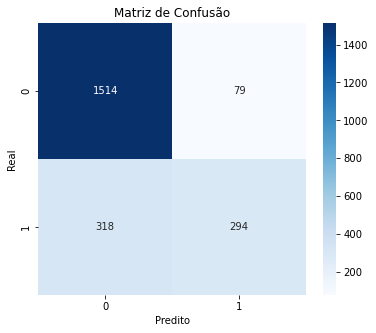

In [46]:
# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, 
                              eval_metric="mlogloss",
                              subsample= 0.6,
                              n_estimators=100,
                              min_child_weight= 3,
                              max_depth= 7,
                              learning_rate= 0.2,
                              gamma= 0.2,
                              colsample_bytree= 1.0)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(x_test)
print(f"\nModelo: XGBClassifier")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Criar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Criar a visualização
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# RESULTADO FINAL

In [47]:
# O metodo escolhido foi o XGBoost
pickle.dump(xgb_model,open('model/model_xgboost.pkl','wb'))

In [54]:
# Aplicando base de teste
df_api_t = df_teste

In [55]:
# Convertendo para json
data = json.dumps(df_api_t.to_dict(orient='records'))

In [56]:
# API call
# url = 'http://0.0.0.0:5000/model_churn/predict'
url = 'http://192.168.1.3:5000/model_churn/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post(url,data=data,headers = header)

print('Status Code {}'.format(r.status_code))

Status Code 200


In [57]:
res = pd.DataFrame(r.json(),columns=r.json()[0].keys())
res

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,predictedValues
0,10001,15798485,Copley,565,France,Male,31,1,0.00,1,0,1,20443.08,0
1,10002,15588959,T'ang,569,France,Male,34,4,0.00,1,0,1,4045.90,0
2,10003,15624896,Ku,669,France,Female,20,7,0.00,2,1,0,128838.67,0
3,10004,15639629,McConnan,694,France,Male,39,4,173255.48,1,1,1,81293.10,0
4,10005,15638852,Ts'ui,504,Spain,Male,28,10,109291.36,1,1,1,187593.15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10996,15730373,Starks,531,France,Female,34,10,118306.79,1,1,0,26493.05,0
996,10997,15716191,Dixon,575,Germany,Male,49,2,136822.70,1,1,0,2487.74,1
997,10998,15673900,Wilkinson,520,France,Female,74,4,0.00,1,0,0,26742.92,0
998,10999,15581432,Oatley,675,Spain,Male,23,8,0.00,2,0,0,162342.21,0


In [295]:
#res.to_csv('predicao_Abandono_teste.csv',index=False)

In [58]:
res_final = res[['RowNumber','predictedValues']]
res_final.to_csv('prediction_Abandono_teste.csv',index=False)